In [ ]:
import os
import scipy.io
from scipy.stats import ranksums
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from learned_tuning.learned_tuning import calculate_learned_tuning_PBE_subsets, calculate_place_field_fidelity_of_learned_tuning


data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# included_session_IDX = [x for x in range(17) if x not in (9, 10)]
included_session_IDX = [1]

sessions = [sessions[i] for i in included_session_IDX]

for session_name in sessions:

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)


    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
   


     #----------------------------------------------------------------------------------------------
    # Load spike data

    filename = f'{session_name}.spikes_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    spikes_pyr = mat_file["spikes_pyr"]

    #### Extracting all place fields from the imported .mat file
    spatial_tuning_smoothed = spikes_pyr["spatialTuning_smoothed"]

    num_units    = spatial_tuning_smoothed[0].shape[0]
    # num_units    = spatial_tuning_smoothed.shape[0] # for RatN only

    num_pos_bins = spatial_tuning_smoothed[0][0]['uni'][0][0].size

    # print(num_units, num_pos_bins)

    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units):
        
        # Create dictionaries for each unit and store the matrices
        
        unit_spikes = dict()
        
        unit_spikes['place_fields']  = {}
        unit_spikes['peak_pos_bins'] = {}

        
        for direction in running_directions:
            try:
                unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[0][unit][direction][0][0].reshape(num_pos_bins) 
                unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]

                # unit_spikes['place_fields'][direction] = spatial_tuning_smoothed[unit][0][direction][0][0].reshape(num_pos_bins) 
                # unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1


        unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
        unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]
        unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        # unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] # for RatN and RatS
        # unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]
        # unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]
        
            
        spikes.append(unit_spikes) 

    # place fields by pooling spikes across both running directions
    place_fields_uni = []
    for unit in range(num_units):
        place_fields_uni.append(spikes[unit]['place_fields']['uni'])
    place_fields_uni = np.array(place_fields_uni)

    place_fields_uni[place_fields_uni == 0] = 1e-4




    # --------------------------------------------------------------------------------------------
    # Load cluster quality data (L-ratios)
    
    filename = f'{session_name}.clusterQuality.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)

    # Access data structure
    num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

    L_ratios = list()
    for shank in range(num_shanks):    
        curr_shank_L_ratios = dict()
        curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
        curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
        
        L_ratios.append(curr_shank_L_ratios)
    # L_ratios = []


    #-------------------------------------------------------------------------------------------------
    # Population Burst Events (PBEs)

    filename = f'{session_name}.PBEInfo_replayScores.mat'
    # filename = f'{session_name}.PBEInfo.mat'


    file_path = os.path.join(session_dataset_path, filename)
    f = h5py.File(file_path, "r")

    PBEInfo = f['PBEInfo_replayScores']
    # PBEInfo = f['PBEInfo_Bayesian']



    # Store the population burst events in an object easy to work with in Python 
    PBEs = []
    num_PBEs = PBEInfo["fr_1msbin"].shape[0]
    attributes = list(PBEInfo.keys())

    # Loop over the PBEs and create a dictionary for each one
    num_dots = int(num_PBEs * (10/100))

    count = 0
    for pbe in range(num_PBEs): #   
        # Create a dictionary for the PBE and store the matrices
        PBE_dict = {}
        for attr in attributes:
            ref = PBEInfo[attr][pbe][0]
            obj = f[ref] 
            PBE_dict[attr] = np.array(obj) 

        PBEs.append(PBE_dict)

        if (pbe+1) % num_dots == 1:
            count += 1
            message = "Importing PBEs" + "." * count
            print(message, end="\r")

    print("All PBEs were imported")


    #----------------------------------------------------------------------------------------------------
    # Import results of learned tuning calculation in MALAB

    # Load .mat file
    filename = f'{session_name}.assemblyTunings_allPBEs_Lthresh1e_3.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)

    active_units = dict()

    active_units["pre"] = mat_file["activeUnits"]["pre"][0][0]
    active_units["maze"] = mat_file["activeUnits"]["run"][0][0]
    active_units["post"] = mat_file["activeUnits"]["post"][0][0]

    active_units_epochs_intersect = np.intersect1d(np.intersect1d(active_units["pre"], active_units["post"]), active_units["maze"])
    active_units_epochs_intersect = active_units_epochs_intersect - 1 # to make the indices compatible with the python indexing


    #------------------------------------------------------------------------------------------------------
    # Learned tunings during Non-REM versus Quiet Wake ripples


    # The frequency of PBEs ocurring during NREM ('N') or quiet wake ('W')

    num_PBEs = len(PBEs)
    PBEs_peak_time = np.zeros((num_PBEs, 1))
    brain_state_first_letter = np.empty((num_PBEs, 1), dtype='str')

    for pbe in range(num_PBEs):
        PBEs_peak_time[pbe] = PBEs[pbe]["peakT"]
        brain_state_first_letter[pbe]= chr(np.concatenate(PBEs[pbe]["brainState"])[0])


    # Calculate learned tunings separately for NREM and QW PBEs and calculate thier PF fidleities
    time_win_duration = 900 # 15 minutes
    step_duration = 300 # 5 minutes
    win_centers = {}

    time_bin_duration=0.02
    num_PF_shuffles = 10000
    learned_tunings_vs_time_NREM_vs_QW = {}  # create an empty dictionary to store the results
    

    for epoch in ['PRE', 'POST']:
        if epoch == 'PRE':
            epoch_idx = 0
            epoch_duration = epochs[0,1] - epochs[0,0]
        elif epoch == 'POST':
            epoch_idx = 2
            epoch_duration = epochs[2,1] - epochs[2,0]
            
        # PBEs for the current epoch
        
        if_inside_epoch = (PBEs_peak_time >= epochs[epoch_idx,0]) & (PBEs_peak_time <= epochs[epoch_idx,0]+epoch_duration)


        # NREM PBEs
        select_IDX_NREM = np.where(np.logical_and(if_inside_epoch, brain_state_first_letter == 'N'))[0]
        epoch_NREM_PBEs = np.take(PBEs, select_IDX_NREM)
        PBEs_peak_time_NREM = PBEs_peak_time[select_IDX_NREM]
        num_PBEs_NREM = len(epoch_NREM_PBEs)

        # QW PBEs
        select_IDX_QW = np.where(np.logical_and(if_inside_epoch, brain_state_first_letter == 'Q'))[0]
        epoch_QW_PBEs = np.take(PBEs, select_IDX_QW)
        PBEs_peak_time_QW = PBEs_peak_time[select_IDX_QW]
        num_PBEs_QW = len(epoch_QW_PBEs)


        # learned tunings across time


        num_time_wins = np.floor((epoch_duration-time_win_duration)/step_duration).astype(int)

        if epoch_idx == 2:
            win_start_times = epochs[epoch_idx, 0] + np.arange(num_time_wins)*step_duration
            win_end_times = win_start_times + time_win_duration
            
        elif epoch_idx == 0:
            win_end_times = epochs[epoch_idx, 1] - np.arange(num_time_wins)*step_duration
            win_start_times = win_end_times - time_win_duration

        win_centers[epoch] = win_start_times + time_win_duration/2

        # sorting the windows chronologically 
        sort_indices = np.argsort(win_centers[epoch])

        win_centers[epoch] = win_centers[epoch][sort_indices]
        win_start_times = win_start_times[sort_indices]
        win_end_times = win_end_times[sort_indices]


        PBEs_indices_per_win_NREM = [None for _ in range(num_time_wins)]
        num_PBEs_per_win_NREM = []
        PBEs_indices_per_win_QW = [None for _ in range(num_time_wins)]
        num_PBEs_per_win_QW = []

        for win in range(num_time_wins):

            PBEs_indices_per_win_NREM[win] = np.where((PBEs_peak_time_NREM >= win_start_times[win]) & (PBEs_peak_time_NREM <= win_end_times[win]))[0]
            num_PBEs_per_win_NREM.append(len(PBEs_indices_per_win_NREM[win]))

            PBEs_indices_per_win_QW[win] = np.where((PBEs_peak_time_QW >= win_start_times[win]) & (PBEs_peak_time_QW <= win_end_times[win]))[0]
            num_PBEs_per_win_QW.append(len(PBEs_indices_per_win_QW[win]))




        # NREM #################

        # Calculate the learned tunings
        print(f"calculating learned tunings using NREM PBEs in {epoch}")
        learned_tunings_NREM_across_time = calculate_learned_tuning_PBE_subsets(epoch_NREM_PBEs, spikes, PBEs_indices_per_win_NREM, L_ratios, time_bin_duration)

        # Calculate the PF fidelity of the NREM learned tunings
        learned_tuning_place_field_pearson_corr_NREM_across_time = np.full((num_units, num_time_wins), np.nan)
        median_LT_PF_pearson_corr_NREM_across_time = [None for _ in range(num_time_wins)]

        for win in range(num_time_wins):
            learned_tuning_place_field_pearson_corr_NREM_across_time[active_units_epochs_intersect, win], median_LT_PF_pearson_corr_NREM_across_time[win] = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings_NREM_across_time[active_units_epochs_intersect, :, win], 
                place_fields_uni[active_units_epochs_intersect, :], 
                num_PF_shuffles)



        # QW ###################

        # Calculate the learned tunings
        print(f"calculating learned tunings using QW PBEs in {epoch}")
        learned_tunings_QW_across_time = calculate_learned_tuning_PBE_subsets(epoch_QW_PBEs, spikes, PBEs_indices_per_win_QW, L_ratios, time_bin_duration)
        
        # Calculate the PF fidelity of the QW learned tunings
        learned_tuning_place_field_pearson_corr_QW_across_time = np.full((num_units, num_time_wins), np.nan)
        median_LT_PF_pearson_corr_QW_across_time = [None for _ in range(num_time_wins)]

        for win in range(num_time_wins):
            learned_tuning_place_field_pearson_corr_QW_across_time[active_units_epochs_intersect, win], median_LT_PF_pearson_corr_QW_across_time[win] = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings_QW_across_time[active_units_epochs_intersect, :, win], 
                place_fields_uni[active_units_epochs_intersect, :], 
                num_PF_shuffles)


        # Store the results
        learned_tunings_vs_time_NREM_vs_QW[epoch] = {
            'learned_tunings_NREM_across_time': learned_tunings_NREM_across_time,
            'learned_tuning_place_field_pearson_corr_NREM_across_time': learned_tuning_place_field_pearson_corr_NREM_across_time,
            'median_LT_PF_pearson_corr_NREM_across_time': median_LT_PF_pearson_corr_NREM_across_time,
            'num_PBEs_per_win_NREM':num_PBEs_per_win_NREM,
            'learned_tunings_QW_across_time': learned_tunings_QW_across_time,
            'learned_tuning_place_field_pearson_corr_QW_across_time': learned_tuning_place_field_pearson_corr_QW_across_time,
            'median_LT_PF_pearson_corr_QW_across_time': median_LT_PF_pearson_corr_QW_across_time,
            'num_PBEs_per_win_QW':num_PBEs_per_win_QW,
            'win_centers': win_centers
        }


    filename = f'{session_name}.learned_tunings_vs_time_NREM_vs_QW.npy'
    file_path = os.path.join(session_dataset_path, filename)
    np.save(file_path, learned_tunings_vs_time_NREM_vs_QW)
                                                                                                                                                                                                                                                                                                                                                   


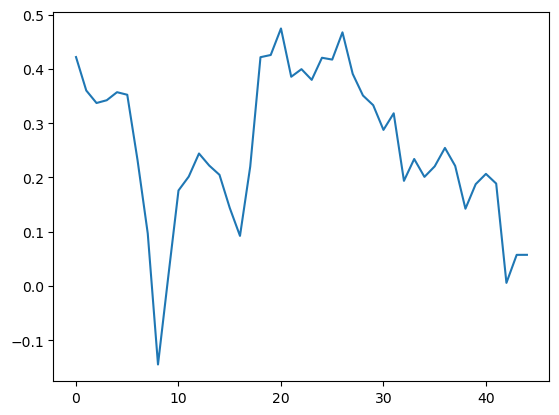

In [36]:
median_LT_PF_corr = []
for win in range(num_time_wins):
    median_LT_PF_corr.append(learned_tunings_vs_time_NREM_vs_QW['POST']['median_LT_PF_pearson_corr_QW_across_time'][win]["data"])
plt.plot(median_LT_PF_corr)


/tmp/ipykernel_87761/1284213805.py:9: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = matrix / col_max[np.newaxis, :]


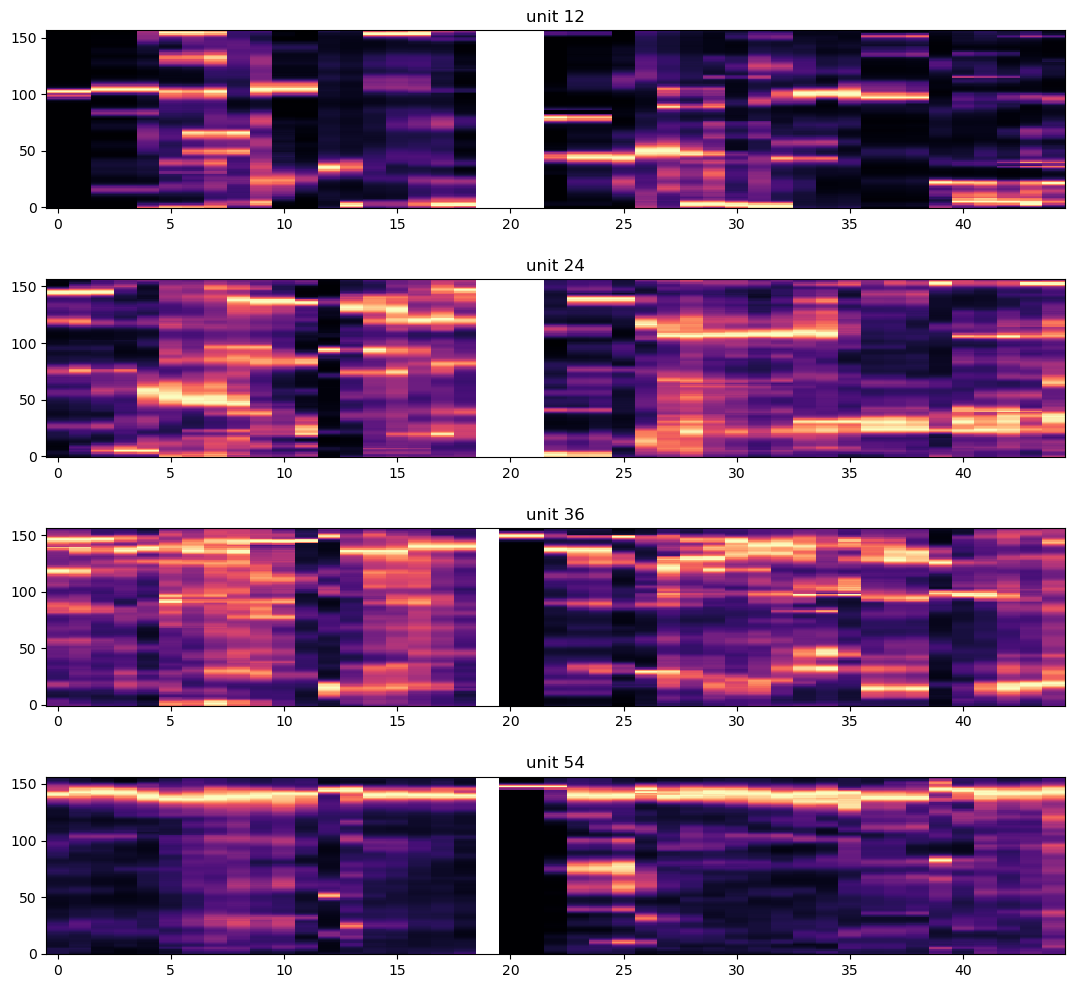

In [85]:
def max_normalize_columns(matrix):
    """
    Takes a matrix as input and returns a new matrix where each column sums up to one (a probability distribution)
    """
    # calculate the sum of each column
    col_max = np.max(matrix, axis=0)
    
    # divide each element in a column by its sum
    normalized_matrix = matrix / col_max[np.newaxis, :]
    
    return normalized_matrix


units_t_plot = [12, 24, 36, 54]

fig, axes = plt.subplots(4,1, gridspec_kw = {'hspace':0.4, 'wspace': 0.4}, ) #
fig.set_size_inches(18,12)

for i, curr_unit in enumerate(units_t_plot):

    curr_LT_vs_time = learned_tunings_vs_time_NREM_vs_QW['POST']['learned_tunings_NREM_across_time'][curr_unit, :, :]
    binCenters = learned_tunings_vs_time_NREM_vs_QW['POST']


    curr_LT_vs_time = max_normalize_columns(curr_LT_vs_time) 
    axes[i].imshow(curr_LT_vs_time, interpolation='nearest', origin = 'lower', cmap='magma')
    axes[i].set_title(f"unit {curr_unit}")
    # axes[i].margins(0)
    axes[i].set_aspect(0.05)

# plt.subplots_adjust(left=0.05, right = 0.95, top = 0.95, bottom = 0.05)

plt.savefig('/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/Buddy_06272013/test.svg')

plt.show()

In [50]:
i

(0, 12)